## 1. Intelligent Document Intake & Triage Agent (Junior)

**Use case:** Law firms, insurance, HR, banks
Automatically classifies incoming documents and routes them.

**Agentic behavior**

* Multi-step reasoning: extract → classify → validate → route
* Tool calling: OCR, parsers, vector DB, rules engine
* Confidence scoring + fallback paths

**Production requirements**

* Async ingestion pipeline
* Idempotent processing
* Structured outputs (Pydantic)
* Audit logs for every decision
* Retry + dead-letter queue

👉 If your “RAG agent” can’t do this, it’s not production-ready.

---
# First Step: Prototyping Classifying Step

**Thought ProcesS**

- I am creating an llm model that classifies the document and outputs in a specific structred format

- Now I'm creating a class for the structured output which inherits from the base model class in pydantic

- Creating certain class atributes that will help in logging the activity

> - document_type: Returns a Literal classification of the Document

> - confidence: Return the confidence for the classifiction between 0 and 1

> - alternative_types: Gives two alternative classifications

> - reasoning: Gives the reason the model gave the classification

> - key_indicatiors: Returns a list of indicators that the model referred to make the classification

In [1]:
from langchain_groq import ChatGroq
from typing import Literal
from pydantic import BaseModel, Field

# Define what classification looks like (this is your contract)``
class DocumentClassification(BaseModel):
    """Structured output for document classification"""
    document_type: Literal[
        "invoice",
        "contract", 
        "w2_form",
        "medical_record",
        "insurance_claim",
        "purchase_order",
        "unknown"
    ] = Field(description="The primary document type")
    
    confidence: float = Field(
        ge=0.0,
        le=1.0,
        description="Confidence score (0.0-1.0) for the classification"
    )
    
    alternative_types: list[str] = Field(description='Top 2 alternative classifications if confidence < 0.8')
    
    reasoning: str = Field(description='Brief explaination of why was the classification choosen')
    
    key_indicators: list[str] = Field(
        description="Specific text/fields that indicated this document type (e.g., 'INVOICE #', 'W-2', 'CLAIM NUMBER')"
    )

llm = ChatGroq(model='llama-3.3-70b-versatile')
classifier = llm.with_structured_output(DocumentClassification)

c:\Users\DELL\.conda\envs\langchain-portfolio\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
classifier.invoke('Data/Muhammad_Umar_Resume.pdf')

DocumentClassification(document_type='unknown', confidence=0.5, alternative_types=['contract', 'invoice'], reasoning="The document appears to be a resume based on the presence of the name 'Muhammad Umar' and the file name 'Resume', but the confidence is low due to the lack of specific keywords or phrases that are commonly found in resumes.", key_indicators=['Muhammad Umar', 'Resume'])

- Now here we create a Langgraph Graph to experiment with the ideas

In [ ]:
# System prompt that guides classification
system_prompt = """You are an expert document classifier. Analyze the provided document and determine its type.

IMPORTANT RULES:
1. Be strict about classification—only assign a type if you're confident
2. Look for specific indicators (logos, header text, field names)
3. If you're unsure between types, set confidence accordingly
4. Provide specific quotes or sections that led to your decision

Document Types You Can Classify:
- invoice: Has vendor name, invoice #, line items, amounts, due date
- contract: Has parties, terms, signatures, effective dates, legal language
- w2_form: IRS form, employee tax, boxes 1-12, wage/tax info
- medical_record: Patient info, diagnoses, procedures, prescriptions, provider letterhead
- insurance_claim: Claim #, policy #, incident details, coverage info
- purchase_order: PO number, vendor, line items, delivery date, approval"""


- Declaring the state of the graph and then function for the node

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph, END
from langchain_classic.schema import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
# Define state as TypedDict (LangGraph requirement)
class TriageState(TypedDict):
    document_id: str
    document_content: str | Document | list[str] | list[Document]# Raw Text or OCR Output
    document_type: str | None  # Optional
    confidence_score: float
    classification_details: dict  # Stores full reasoning
    

def classify_with_fallback(state: TriageState) -> dict:
    """
    Two-pass classification: simple first, then detailed if uncertain.
    """
    
    # Extract text from Document objects
    
    # PASS 1: Quick classification
    quick_classification = classifier.invoke(
        [
            SystemMessage(content="Classify this document type quickly. Choose the best match."),
            HumanMessage(content=state['document_content'][:2000])  # First 2000 chars
        ]
    )
    
    # If confidence is good, return it
    if quick_classification.confidence >= 0.8:
        return {
            "document_type": quick_classification.document_type,
            "confidence_score": quick_classification.confidence,
            "classification_details": {
                "reasoning": quick_classification.reasoning,
                "key_indicators": quick_classification.key_indicators,
                "alternatives": quick_classification.alternative_types,
                "pass": 1  # Track which pass succeeded
            }
        }
    
    # PASS 2: Detailed analysis for low-confidence documents
    detailed_classification = classifier.invoke(
        [
            SystemMessage(
                content=system_prompt,
            ),
            HumanMessage(content=state['document_content'])  # Full content
        ]
    )
    
    return {
        "document_type": detailed_classification.document_type,
        "confidence_score": detailed_classification.confidence,
        "classification_details": {
            "reasoning": detailed_classification.reasoning,
            "key_indicators": detailed_classification.key_indicators,
            "alternatives": detailed_classification.alternative_types,
            "pass": 2,  # Indicates we needed detailed analysis
        }
    }
    



In [ ]:
# Add to your graph
builder = StateGraph(TriageState)
builder.add_node("classify", classify_with_fallback)
builder.add_edge(START, "classify")


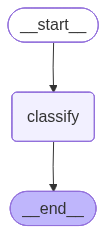

In [ ]:
agent = builder.compile()
agent

- Testing the Graph

In [ ]:
initial_state: TriageState = {
    "document_id": "doc_001",
    "document_content": "Invoice #1234\nTotal Amount: $450\nDue Date: 10 Jan 2026",
    "document_type": None,
    "confidence_score": 0.0,
    "classification_details": {}
}

result = agent.invoke(initial_state)

print(result)

{'document_id': 'doc_001', 'document_content': 'Invoice #1234\nTotal Amount: $450\nDue Date: 10 Jan 2026', 'document_type': 'invoice', 'confidence_score': 0.9, 'classification_details': {'reasoning': "The presence of 'Invoice #', 'Total Amount', and 'Due Date' indicate that the document is an invoice", 'key_indicators': ['INVOICE #', 'Total Amount', 'Due Date'], 'alternatives': ['contract', 'purchase_order'], 'pass': 1}}


In [ ]:
print(result['document_type'])
print(result['confidence_score'])
print(result['classification_details'])
print(result['classification_details']['pass'])



# Prototyping Validation Layer

- ## Declaring Document Rules

In [11]:
DOCUMENT_RULES = {
    "invoice": """
    - Should contain invoice number, vendor, and total amount.
    - Look for dates (issue/due), line items, and currency symbols.
    - Must clearly identify sender and recipient details.
    - Confidence threshold: >=0.8 to auto-route to Accounting.
    """,

    "contract": """
    - Should include parties involved, effective dates, and terms.
    - Look for legal clauses, signatures, and titles like 'Agreement' or 'Contract'.
    - Ensure the document is not a draft (check for 'DRAFT' watermark).
    - Confidence threshold: >=0.85 to auto-route to Legal.
    """,

    "w2_form": """
    - Must include employee name, SSN, and employer info.
    - Look for 'W-2' title, federal tax info, and wages.
    - Ensure all required fields are filled.
    - Confidence threshold: >=0.9 to auto-route to HR.
    """,

    "medical_record": """
    - Should contain patient info, medical history, and dates of service.
    - Look for headings like 'Diagnosis', 'Prescription', 'Lab Results'.
    - Ensure PHI compliance; anonymize if necessary.
    - Confidence threshold: >=0.8 to auto-route to Medical Records.
    """,

    "insurance_claim": """
    - Must include claim number, policy number, and claim type.
    - Look for accident dates, insured party, and supporting documents.
    - Ensure signatures or stamps are present if required.
    - Confidence threshold: >=0.8 to auto-route to Claims department.
    """,

    "purchase_order": """
    - Should include PO number, vendor info, and item list with quantities.
    - Look for delivery dates, pricing, and approval signatures.
    - Confidence threshold: >=0.85 to auto-route to Procurement.
    """,

    "unknown": """
    - Document type could not be determined with high confidence.
    - Route to Manual Review queue for human inspection.
    - No auto-routing allowed.
    """
}


- ## Giving a system prompt

In [18]:

system_prompt = """

You are a document validation engine.

Your task is to evaluate whether a document satisfies
the validation rules for a given document type.

You MUST:
- Use only the provided validation rules
- Identify evidence directly from the document text
- Explicitly list rule matches and violations
- Decide a final validation status

You MUST NOT:
- Reclassify the document
- Invent new rules
- Assume missing information
- Modify the document type

Your output MUST be valid JSON and follow the schema exactly.


"""

human_prompt = """

PROPOSED LABEL:
{label}

CLASSIFIER CONFIDENCE:
{confidence}

AMBIGUOUS FLAG:
{ambiguous}

VALIDATION RULES:
{rules}

DOCUMENT CONTENT:
{content}

TASK:
Evaluate the document against the validation rules and return:

- matched_required_rules
- missing_required_rules
- forbidden_hits (if any)
- validation_decision: VALID | WEAK | INVALID
- justification (short, factual)



"""

- ## Implementing a Structured Output Schema

In [19]:
from pydantic import BaseModel, Field
from typing import Literal, List

class DocumentValidation(BaseModel):
    """
    Structured output for document classification validation.
    This model DOES NOT re-classify documents.
    """

    validated_label: Literal[
        "invoice",
        "contract",
        "w2_form",
        "medical_record",
        "insurance_claim",
        "purchase_order",
        "unknown"
    ] = Field(
        description="The label being validated. This must match the upstream classifier output."
    )

    classifier_confidence: float = Field(
        ge=0.0,
        le=1.0,
        description="Original confidence score produced by the classifier."
    )

    validation_decision: Literal[
        "VALID",
        "WEAK",
        "INVALID"
    ] = Field(
        description="Validation result based on rule matching and contradictions."
    )

    matched_rules: List[str] = Field(
        description="Required rules that were clearly satisfied by the document."
    )

    missing_required_rules: List[str] = Field(
        description="Required rules that were expected but not found."
    )

    forbidden_rule_hits: List[str] = Field(
        description="Rules that should NOT appear for this document type but were detected."
    )

    justification: str = Field(
        description="Concise explanation referencing rules only. No reclassification."
    )


In [20]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([system_prompt, human_prompt])


In [21]:
llm = ChatGroq(model='llama-3.3-70b-versatile', temperature=0.0)
llm_with_structure = llm.with_structured_output(DocumentValidation)

In [22]:
def validate_document(
    content: str,
    label: str,
    confidence: float,
    ambiguous: bool
) -> DocumentValidation:

    rules = DOCUMENT_RULES.get(label, [])

    chain = prompt | llm

    result: DocumentValidation = chain.invoke({
        "content": content,
        "label": label,
        "confidence": confidence,
        "ambiguous": ambiguous,
        "rules": rules
    })

    return result


In [23]:
test_content = """
Invoice Number: INV-10293
Vendor: Acme Supplies Ltd.
Billing Date: 12-Dec-2025
Due Date: 26-Dec-2025

Item            Qty   Price
Laptop Stand     2    $40
USB Cable        5    $10

Total Amount: $130
"""

test_label = "invoice"
test_confidence = 0.92
test_ambiguous = False

result = validate_document(
    content=test_content,
    label=test_label,
    confidence=test_confidence,
    ambiguous=test_ambiguous
)




In [24]:
result

AIMessage(content='```json\n{\n  "matched_required_rules": [\n    "Should contain invoice number, vendor, and total amount.",\n    "Must clearly identify sender and recipient details is not fully met, but vendor is identified",\n    "Look for dates (issue/due)"\n  ],\n  "missing_required_rules": [\n    "Line items are present but sender and recipient details are not fully specified",\n    "Currency symbol is present but confidence threshold for auto-routing is not applicable here"\n  ],\n  "forbidden_hits": [],\n  "validation_decision": "WEAK",\n  "justification": "The document contains key elements like invoice number, vendor, and total amount, but lacks full sender and recipient details."\n}\n```', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 145, 'prompt_tokens': 343, 'total_tokens': 488, 'completion_time': 0.484121904, 'completion_tokens_details': None, 'prompt_time': 0.033257647, 'prompt_tokens_details': None, 'queue_time': 0.160861613, 'total_time